In [2]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tensorflow.keras.utils import load_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, BatchNormalization, Activation, Dropout, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, TensorBoard, EarlyStopping, ReduceLROnPlateau
import datetime
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model
from collections import defaultdict

In [3]:
# RUN ONLY ONCE EVER

import os
import cv2

base_path = "Cheat Database"
output_path = "cheat_database_frame"

os.makedirs(output_path, exist_ok=True)

for scenario in sorted(os.listdir(base_path)):
    scenario_path = os.path.join(base_path, scenario)
    if not os.path.isdir(scenario_path):
        continue

    output_scenario_path = os.path.join(output_path, scenario)
    os.makedirs(output_scenario_path, exist_ok=True)

    for filename in os.listdir(scenario_path):
        if not filename.endswith(".jpg"):
            continue

        img_path = os.path.join(scenario_path, filename)
        txt_path = img_path.replace(".jpg", ".txt")

        img = cv2.imread(img_path)
        if img is None:
            continue
        h, w = img.shape[:2]

        if os.path.exists(txt_path):
            with open(txt_path, "r") as f:
                for line in f:
                    class_id, x_center, y_center, box_w, box_h = map(float, line.strip().split())
                    x1 = int((x_center - box_w / 2) * w)
                    y1 = int((y_center - box_h / 2) * h)
                    x2 = int((x_center + box_w / 2) * w)
                    y2 = int((y_center + box_h / 2) * h)
                    cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
                    cv2.putText(img, f"Class {int(class_id)}", (x1, y1 - 5),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1)

        out_file_path = os.path.join(output_scenario_path, filename)
        cv2.imwrite(out_file_path, img)


In [ ]:
# RUN ONLY ONCE EVER

import os
import shutil
import random
from collections import defaultdict

random.seed(42)

input_base = "cheat_database_frame"
output_base = "dataset"

scenario_labels = {
    "Scenario {}".format(i): int(i >= 4 and (
        i in [4,5,10,11,13,16,17,22,23] or i >= 37)) for i in range(1, 61)
}

# Collect images grouped by label
grouped_images = defaultdict(list)

for scenario, label in scenario_labels.items():
    scenario_path = os.path.join(input_base, scenario)
    if not os.path.isdir(scenario_path):
        continue

    for img_file in os.listdir(scenario_path):
        if img_file.lower().endswith((".jpg", ".jpeg", ".png")):
            img_path = os.path.join(scenario_path, img_file)
            grouped_images[label].append(img_path)

# Split and copy
for label, images in grouped_images.items():
    random.shuffle(images)
    split_idx = int(0.8 * len(images))
    train_imgs = images[:split_idx]
    test_imgs = images[split_idx:]

    label_name = "cheat" if label == 1 else "non_cheat"

    for split, img_list in [("train", train_imgs), ("test", test_imgs)]:
        split_dir = os.path.join(output_base, split, label_name)
        os.makedirs(split_dir, exist_ok=True)

        for img_path in img_list:
            fname = os.path.basename(img_path)
            dst = os.path.join(split_dir, fname)
            shutil.copy(img_path, dst)


In [9]:
# Paths
train_dir = "dataset/train"
test_dir = "dataset/test"
img_size = 224
batch_size = 32

In [10]:
# Data loaders
train_gen = ImageDataGenerator(rescale=1./255)
test_gen = ImageDataGenerator(rescale=1./255)

In [11]:
train_data = train_gen.flow_from_directory(
    train_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='binary'
)

Found 12040 images belonging to 2 classes.


In [12]:
test_data = test_gen.flow_from_directory(
    test_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='binary'
)

Found 3030 images belonging to 2 classes.


In [7]:
# CNN Model
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(img_size, img_size, 3)),
    MaxPooling2D(2,2),
    
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Binary classification
])

/home/mush/git/github/Cheat-Detector/cheat/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1743883549.083553   20858 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5100 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3070 Ti Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


In [59]:
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])


In [9]:

# Training
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_data.classes),
    y=train_data.classes
)
class_weights = dict(enumerate(class_weights))

history = model.fit(
    train_data,
    epochs=15,
    validation_data=test_data,
    callbacks=[early_stop],
    class_weight=class_weights,
    verbose = 1
)



Epoch 1/15


/home/mush/git/github/Cheat-Detector/cheat/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1743883556.903326   20983 service.cc:152] XLA service 0x7aae9800ac00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1743883556.903348   20983 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Ti Laptop GPU, Compute Capability 8.6
2025-04-06 01:35:56.925076: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1743883557.077921   20983 cuda_dnn.cc:529] Loaded cuDNN version 90800


  4/377 ━━━━━━━━━━━━━━━━━━━━ 19s 53ms/step - accuracy: 0.5495 - loss: 0.6965

I0000 00:00:1743883558.815678   20983 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


377/377 ━━━━━━━━━━━━━━━━━━━━ 38s 93ms/step - accuracy: 0.8046 - loss: 0.4212 - val_accuracy: 0.8871 - val_loss: 0.2386
Epoch 2/15
377/377 ━━━━━━━━━━━━━━━━━━━━ 33s 87ms/step - accuracy: 0.9070 - loss: 0.2038 - val_accuracy: 0.9020 - val_loss: 0.1953
Epoch 3/15
377/377 ━━━━━━━━━━━━━━━━━━━━ 33s 87ms/step - accuracy: 0.9279 - loss: 0.1585 - val_accuracy: 0.9320 - val_loss: 0.1502
Epoch 4/15
377/377 ━━━━━━━━━━━━━━━━━━━━ 32s 84ms/step - accuracy: 0.9412 - loss: 0.1358 - val_accuracy: 0.9545 - val_loss: 0.1181
Epoch 5/15
377/377 ━━━━━━━━━━━━━━━━━━━━ 33s 87ms/step - accuracy: 0.9559 - loss: 0.1067 - val_accuracy: 0.9558 - val_loss: 0.1037
Epoch 6/15
377/377 ━━━━━━━━━━━━━━━━━━━━ 35s 92ms/step - accuracy: 0.9638 - loss: 0.0947 - val_accuracy: 0.9663 - val_loss: 0.0859
Epoch 7/15
377/377 ━━━━━━━━━━━━━━━━━━━━ 32s 85ms/step - accuracy: 0.9742 - loss: 0.0716 - val_accuracy: 0.9802 - val_loss: 0.0699
Epoch 8/15
377/377 ━━━━━━━━━━━━━━━━━━━━ 33s 87ms/step - accuracy: 0.9775 - loss: 0.0664 - val_accurac

In [13]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

img_size = 224  # MobileNetV2 requires 224x224 input

base_model = MobileNetV2(input_shape=(img_size, img_size, 3), include_top=False, weights='imagenet')
base_model.trainable = False  # freeze base model

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

1

In [14]:
history = model.fit(
    train_data,
    validation_data=test_data,
    epochs=15,
    callbacks=[early_stop]
)


Epoch 1/15


I0000 00:00:1743885945.216251   27704 service.cc:152] XLA service 0x7674d8003e30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1743885945.216277   27704 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Ti Laptop GPU, Compute Capability 8.6
2025-04-06 02:15:45.288674: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1743885945.774725   27704 cuda_dnn.cc:529] Loaded cuDNN version 90800
2025-04-06 02:15:48.537608: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-04-06 02:15:48.670568: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmu

  4/377 ━━━━━━━━━━━━━━━━━━━━ 22s 59ms/step - accuracy: 0.4004 - loss: 1.0327

I0000 00:00:1743885950.019776   27704 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


259/377 ━━━━━━━━━━━━━━━━━━━━ 9s 78ms/step - accuracy: 0.7441 - loss: 0.5006

2025-04-06 02:16:12.124562: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-04-06 02:16:12.256393: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


377/377 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.7745 - loss: 0.4522

2025-04-06 02:16:24.447766: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1160', 204 bytes spill stores, 204 bytes spill loads

2025-04-06 02:16:24.538535: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1160_0', 464 bytes spill stores, 1372 bytes spill loads

2025-04-06 02:16:24.821717: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1160', 5616 bytes spill stores, 5612 bytes spill loads

2025-04-06 02:16:24.927948: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1160', 5356 bytes spill stores, 5336 bytes spill loads

2025-04-06 02:16:33.39206

377/377 ━━━━━━━━━━━━━━━━━━━━ 55s 125ms/step - accuracy: 0.7747 - loss: 0.4518 - val_accuracy: 0.8861 - val_loss: 0.2435
Epoch 2/15
377/377 ━━━━━━━━━━━━━━━━━━━━ 37s 99ms/step - accuracy: 0.8906 - loss: 0.2452 - val_accuracy: 0.8904 - val_loss: 0.2078
Epoch 3/15
377/377 ━━━━━━━━━━━━━━━━━━━━ 38s 100ms/step - accuracy: 0.8989 - loss: 0.2208 - val_accuracy: 0.8934 - val_loss: 0.1963
Epoch 4/15
377/377 ━━━━━━━━━━━━━━━━━━━━ 34s 90ms/step - accuracy: 0.9069 - loss: 0.2026 - val_accuracy: 0.9238 - val_loss: 0.1835
Epoch 5/15
377/377 ━━━━━━━━━━━━━━━━━━━━ 39s 103ms/step - accuracy: 0.9076 - loss: 0.1954 - val_accuracy: 0.8993 - val_loss: 0.1814
Epoch 6/15
377/377 ━━━━━━━━━━━━━━━━━━━━ 36s 95ms/step - accuracy: 0.9155 - loss: 0.1850 - val_accuracy: 0.9231 - val_loss: 0.1686
Epoch 7/15
377/377 ━━━━━━━━━━━━━━━━━━━━ 36s 97ms/step - accuracy: 0.9182 - loss: 0.1793 - val_accuracy: 0.9363 - val_loss: 0.1575
Epoch 8/15
377/377 ━━━━━━━━━━━━━━━━━━━━ 36s 95ms/step - accuracy: 0.9238 - loss: 0.1715 - val_accu

In [148]:
# Save model
model.save("cheat_detector_model.h5")


In [15]:
model.save("cheat_detector_model.keras")


In [16]:

# Evaluate
loss, acc = model.evaluate(test_data)
print(f"Test Accuracy: {acc*100:.2f}%")

95/95 ━━━━━━━━━━━━━━━━━━━━ 7s 70ms/step - accuracy: 0.9629 - loss: 0.1171
Test Accuracy: 95.61%


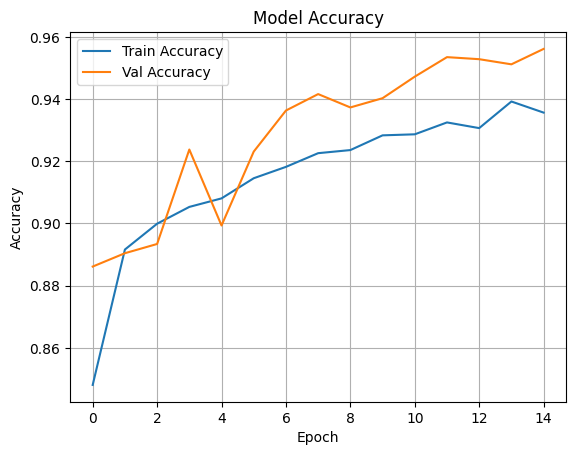

In [17]:
# Accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

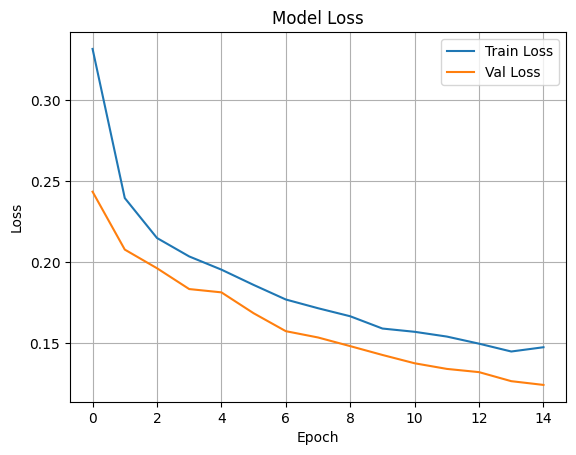

In [18]:
# Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

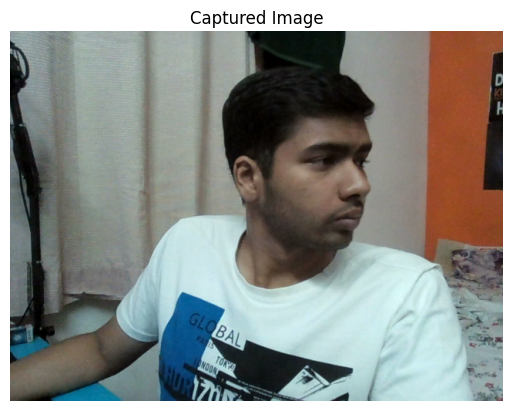

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Prediction: Cheating (78.08% confidence)


In [147]:
from tensorflow.keras.models import load_model
import cv2

# Load trained model
model = load_model("cheat_detector_model.keras")  # path to your saved model

# Set image size (must match training)
img_size = 224  # or whatever size you used in ImageDataGenerator

# Open webcam
cap = cv2.VideoCapture(0)
ret, frame = cap.read()
cap.release()

if not ret:
    print("Failed to capture image.")
else:
    # Display captured image
    import matplotlib.pyplot as plt
    plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title("Captured Image")
    plt.show()

    # Preprocess image
    img = cv2.resize(frame, (img_size, img_size))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img / 255.0
    img = np.expand_dims(img, axis=0)

    # Predict
    prediction = model.predict(img)[0][0]
    label = "Cheating" if prediction > 0.5 else "Not Cheating"
    confidence = prediction if prediction > 0.5 else 1 - prediction

    print(f"Prediction: {label} ({confidence*100:.2f}% confidence)")